目的：ガソリンごとの燃費(ℓ/100km:100km)を推測する。

データ形式はcsv。

表示前にデータをざっと確認。
specials列は天候の内容でAC,rain,sunに反映されているため除外。(snowが気になるが１個だけ)
refill liters,refill gas列はいつ入れたかわからない時系列データなので使い道がなさそう。除外。
予測時に入力されるパラメータを予測すれば引っかからずに済みそう。

In [157]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [158]:
#データを取得：使わないとこはあらかじめ取らない
df_csv = pd.read_csv("../csv/measurements.csv", usecols=lambda x: x not in ['specials', 'refill liters', 'refill gas'])
df_csv

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28,5,26,"21,5",12,E10,0,0,0
1,12,"4,2",30,"21,5",13,E10,0,0,0
2,"11,2","5,5",38,"21,5",15,E10,0,0,0
3,"12,9","3,9",36,"21,5",14,E10,0,0,0
4,"18,5","4,5",46,"21,5",15,E10,0,0,0
5,"8,3","6,4",50,"21,5",10,E10,0,0,0
6,"7,8","4,4",43,"21,5",11,E10,0,0,0
7,"12,3",5,40,"21,5",6,E10,0,0,0
8,"4,9","6,4",26,"21,5",4,E10,0,0,0
9,"11,9","5,3",30,"21,5",9,E10,0,0,0


In [159]:
#欠損チェック
df_csv.isnull().sum()

distance         0
consume          0
speed            0
temp_inside     12
temp_outside     0
gas_type         0
AC               0
rain             0
sun              0
dtype: int64

In [160]:
#少ないので削除
df_csv.dropna(inplace=True)

In [161]:
#質的変数を量的変数に変換：ガソリン種別
df_csv = pd.get_dummies(df_csv, columns=['gas_type'])

In [162]:
#文字列を数値にする
#エラー防止のため欠損チェック
df_csv.isnull().sum()

distance         0
consume          0
speed            0
temp_inside      0
temp_outside     0
AC               0
rain             0
sun              0
gas_type_E10     0
gas_type_SP98    0
dtype: int64

In [163]:
#文字列を数値にするため変換
df_csv['distance'] = df_csv['distance'].str.replace(',', '.')
df_csv['consume'] = df_csv['consume'].str.replace(',', '.')
df_csv['temp_inside'] = df_csv['temp_inside'].str.replace(',', '.')

In [164]:
#数値変換：破壊的に追加(dfが変更される)。
df_csv = df_csv.astype({'distance':'float64', 'consume':'float64', 'temp_inside':'float64'})

In [165]:
df_csv.dtypes

distance         float64
consume          float64
speed              int64
temp_inside      float64
temp_outside       int64
AC                 int64
rain               int64
sun                int64
gas_type_E10       uint8
gas_type_SP98      uint8
dtype: object

In [149]:
#相関係数を表示
df_csv.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_E10,gas_type_SP98
distance,1.000000,-0.131379,0.565505,0.075305,0.086774,-0.027670,-0.022129,0.078627,0.047877,-0.047877
consume,-0.131379,1.000000,-0.234537,-0.161991,-0.318758,0.093892,0.247699,-0.169173,0.020928,-0.020928
speed,0.565505,-0.234537,1.000000,0.059725,0.019327,-0.036351,-0.002936,0.077181,0.099495,-0.099495
temp_inside,0.075305,-0.161991,0.059725,1.000000,0.361308,0.297775,-0.037356,0.246120,-0.010340,0.010340
temp_outside,0.086774,-0.318758,0.019327,0.361308,1.000000,0.169374,-0.185731,0.349988,-0.156990,0.156990
AC,-0.027670,0.093892,-0.036351,0.297775,0.169374,1.000000,0.244848,0.090164,-0.109996,0.109996
rain,-0.022129,0.247699,-0.002936,-0.037356,-0.185731,0.244848,1.000000,-0.113298,-0.059112,0.059112
sun,0.078627,-0.169173,0.077181,0.246120,0.349988,0.090164,-0.113298,1.000000,-0.038120,0.038120
gas_type_E10,0.047877,0.020928,0.099495,-0.010340,-0.156990,-0.109996,-0.059112,-0.038120,1.000000,-1.000000
gas_type_SP98,-0.047877,-0.020928,-0.099495,0.010340,0.156990,0.109996,0.059112,0.038120,-1.000000,1.000000


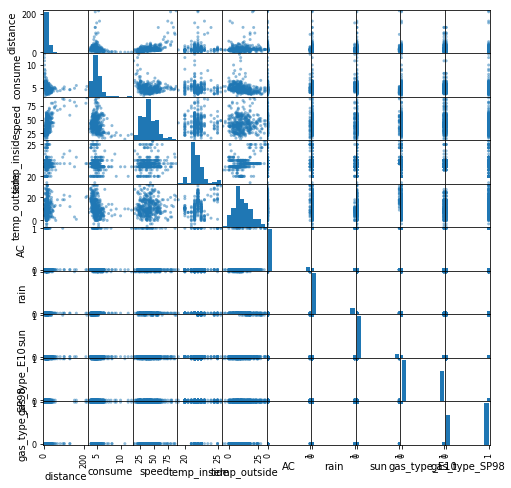

In [150]:
pd.plotting.scatter_matrix(df_csv, figsize=(8,8))
plt.show()

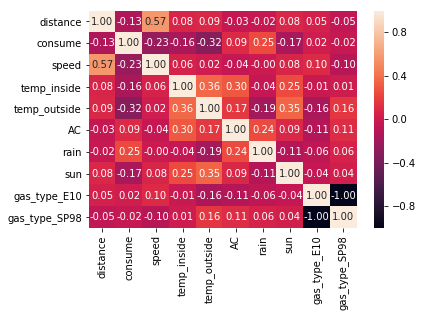

In [151]:
sns.heatmap(df_csv.corr(),annot=True,fmt='.2f')

In [152]:
#ガソリン種類による燃費は同じぐらい

In [153]:
#目的は目的：ガソリンごとの燃費(ℓ/100km:100km)を推測すること。
#よって目的変数はconsume_float
#目的変数の説明となる変数が説明変数なので相関関係にある変数を選択する。
#が、すべての変数が低い相関・相関なしの範囲なのですべての変数を用いる。

In [154]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [155]:
# 係数を求める
y = df_csv["consume"].values
X = df_csv[['distance','speed','temp_inside', 'temp_outside', 'AC', 'rain', 'sun','gas_type_E10','gas_type_SP98']].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [156]:
# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.857
MAE = 0.621
RMSE = 0.926


In [ ]:
#全体の印象
#燃費の誤差0.9ぐらいで予測できる。ちょっと誤差が大きいか。
#ヒートマップからガソリン種類による燃費は同じぐらいなので安いほうを使ったほうがお得。